# Championship 2024/25 – Advanced Attacking Contributors (Forwards Only)

This notebook uses the **merged standard + advanced FBRef player stats** table:

- `data/curated/player_advanced_stats_2024_25.csv`

We focus on **forwards (FW)** with **G+A ≥ 10** and define:

- **Usage** = touches + misplaced passes + shots + miscontrols + dispossessed + failed take-ons  
- **Usage per 90** = Usage / 90s  
- **SCA90** = shot-creating actions per 90 (from FBRef advanced tables)

The scatter plot shows:

- **x-axis**: Usage per 90  
- **y-axis**: SCA90  
- **dot size**: G+A (goals + assists)  
- **colour**: club  
- **diagonal reference line**:  
  \[
  y = x \times \frac{\text{median\_sca90}}{\text{median\_usage\_p90}}
  \]
Players **above the line** generate more SCA than expected for their usage;  
players **below the line** are high-usage but low-return creators.


In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# ------------------------------------------------------------------
# Detect project root (directory that contains the "data" folder)
# ------------------------------------------------------------------
CWD = Path(os.getcwd())

if (CWD / "data").exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / "data").exists():
    PROJECT_ROOT = CWD.parent
else:
    raise RuntimeError("Could not find project root (missing 'data/' folder).")

print("Project root:", PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
CURATED_DIR = DATA_DIR / "curated"

CURATED_DIR


Project root: /Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline


PosixPath('/Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline/data/curated')

In [5]:
adv_path = CURATED_DIR / "player_advanced_stats_2024_25.csv"
print("Loading:", adv_path)

df = pd.read_csv(adv_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:30], "...")

df.head()


Loading: /Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline/data/curated/player_advanced_stats_2024_25.csv
Shape: (765, 47)
Columns: ['club_id', 'club', 'player_name', 'nationality', 'position', 'age', 'born', 'mp', 'starts', 'min', '90s', 'gls', 'ast', 'g+a', 'g-pk', 'pk', 'pkatt', 'crdy', 'crdr', 'xg', 'npxg', 'xag', 'npxg+xag', 'prgc', 'prgp', 'prgr', 'p90_gls', 'p90_ast', 'p90_g+a', 'p90_g-pk'] ...


,club_id,club,player_name,nationality,position,age,born,mp,starts,min,...,misplaced_passes,shots,sca,sca90,gca,gca90,touches,miscontrols,dispossessed,failed_take_ons
0,8,Leeds United,Brenden Aaronson,United States,MF,23.0,2000.0,46,43,3551,...,265,86,145,3.67,13,0.33,1777,103,112,59
1,9,Luton Town,Thelo Aasgaard,Norway,"MF,FW",22.0,2002.0,17,17,1513,...,127,38,39,2.32,1,0.06,692,43,30,24
2,23,Watford,James Abankwah,Republic of Ireland,DF,20.0,2004.0,19,17,1384,...,145,4,16,1.04,1,0.07,1123,11,9,12
3,21,Sunderland,Salis Abdul Samed,Ghana,MF,24.0,2000.0,10,3,283,...,17,0,5,1.59,0,0.00,183,2,0,4
4,22,Swansea City,Azeem Abdulai,Scotland,"FW,MF",21.0,2002.0,17,2,348,...,41,2,4,1.03,0,0.00,196,17,4,3


In [6]:
# ---------------------------------------------------------
# Filter: forwards only (FW) and G+A >= 10
# ---------------------------------------------------------
required_base = ["position", "g+a"]
missing_base = [c for c in required_base if c not in df.columns]
if missing_base:
    raise ValueError(f"Missing required columns: {missing_base}")

# Forwards only
df_fw = df[df["position"].str.contains("FW", na=False)].copy()

# Minimum attacking return
df_fw = df_fw[df_fw["g+a"] >= 10].copy()

print("Forwards with G+A >= 10:", len(df_fw))

# Optional: enforce a minimum game time if you like (uncomment)
# df_fw = df_fw[df_fw["90s"] >= 5].copy()

# ---------------------------------------------------------
# Compute usage and usage per 90
# ---------------------------------------------------------
required_usage = [
    "touches",
    "misplaced_passes",
    "shots",
    "miscontrols",
    "dispossessed",
    "failed_take_ons",
    "90s",
]
missing_usage = [c for c in required_usage if c not in df_fw.columns]
if missing_usage:
    raise ValueError(f"Missing columns needed to compute usage: {missing_usage}")

df_fw["usage"] = (
    df_fw["touches"]
    + df_fw["misplaced_passes"]
    + df_fw["shots"]
    + df_fw["miscontrols"]
    + df_fw["dispossessed"]
    + df_fw["failed_take_ons"]
)

df_fw = df_fw[df_fw["90s"] > 0].copy()
df_fw["usage_p90"] = df_fw["usage"] / df_fw["90s"]

if "sca90" not in df_fw.columns:
    raise ValueError("Expected 'sca90' column (SCA per 90) not found in df_fw.")

print("Rows after usage calc:", len(df_fw))
df_fw[["club", "player_name", "position", "g+a", "usage", "usage_p90", "sca90"]].head()


Forwards with G+A >= 10: 47
Rows after usage calc: 47


,club,player_name,position,g+a,usage,usage_p90,sca90
25,Burnley,Jaidon Anthony,"FW,MF",15,3010,73.955774,4.30
38,Middlesbrough,Finn Azaz,"MF,FW",23,2860,72.588832,4.57
62,Watford,Vakoun Bayo,FW,10,976,39.196787,1.00
81,Portsmouth,Colby Bishop,FW,14,1545,52.910959,2.12
107,Burnley,Josh Brownhill,"MF,FW",24,2616,67.772021,2.82


In [7]:
cols_table = [
    "club",
    "player_name",
    "position",
    "age",
    "90s",
    "g+a",
    "usage",
    "usage_p90",
    "sca90",
]

top_fw_table = (
    df_fw[cols_table]
    .sort_values("g+a", ascending=False)
    .reset_index(drop=True)
)

top_fw_table.head(20)


,club,player_name,position,age,90s,g+a,usage,usage_p90,sca90
0,Leeds United,Joël Piroe,FW,24.0,34.2,26,1530,44.736842,2.43
1,Burnley,Josh Brownhill,"MF,FW",28.0,38.6,24,2616,67.772021,2.82
2,Middlesbrough,Finn Azaz,"MF,FW",23.0,39.4,23,2860,72.588832,4.57
3,Leeds United,Manor Solomon,FW,25.0,28.8,22,1859,64.548611,5.11
4,Norwich City,Borja Sainz,FW,23.0,40.1,22,2350,58.603491,3.19
5,Portsmouth,Josh Murphy,FW,29.0,38.1,21,2227,58.451444,3.26
6,Leeds United,Daniel James,FW,26.0,29.0,21,1669,57.551724,3.28
7,Norwich City,Josh Sargent,FW,24.0,27.8,20,957,34.424460,2.02
8,West Bromwich Albion,Tom Fellows,"FW,MF",21.0,31.9,18,1481,46.426332,3.20
9,Sheffield Wednesday,Josh Windass,"MF,FW",30.0,35.8,18,2030,56.703911,2.93


In [8]:
# Build a colour per club for plotting
clubs = df_fw["club"].astype(str).unique()
clubs_sorted = np.sort(clubs)

cmap = plt.get_cmap("tab20")
num_colors = cmap.N

club_to_color = {
    club: cmap(i % num_colors)
    for i, club in enumerate(clubs_sorted)
}

club_to_color


{'Blackburn Rovers': (np.float64(0.12156862745098039),
  np.float64(0.4666666666666667),
  np.float64(0.7058823529411765),
  np.float64(1.0)),
 'Bristol City': (np.float64(0.6823529411764706),
  np.float64(0.7803921568627451),
  np.float64(0.9098039215686274),
  np.float64(1.0)),
 'Burnley': (np.float64(1.0),
  np.float64(0.4980392156862745),
  np.float64(0.054901960784313725),
  np.float64(1.0)),
 'Cardiff City': (np.float64(1.0),
  np.float64(0.7333333333333333),
  np.float64(0.47058823529411764),
  np.float64(1.0)),
 'Coventry City': (np.float64(0.17254901960784313),
  np.float64(0.6274509803921569),
  np.float64(0.17254901960784313),
  np.float64(1.0)),
 'Derby County': (np.float64(0.596078431372549),
  np.float64(0.8745098039215686),
  np.float64(0.5411764705882353),
  np.float64(1.0)),
 'Leeds United': (np.float64(0.8392156862745098),
  np.float64(0.15294117647058825),
  np.float64(0.1568627450980392),
  np.float64(1.0)),
 'Luton Town': (np.float64(1.0),
  np.float64(0.5960784313

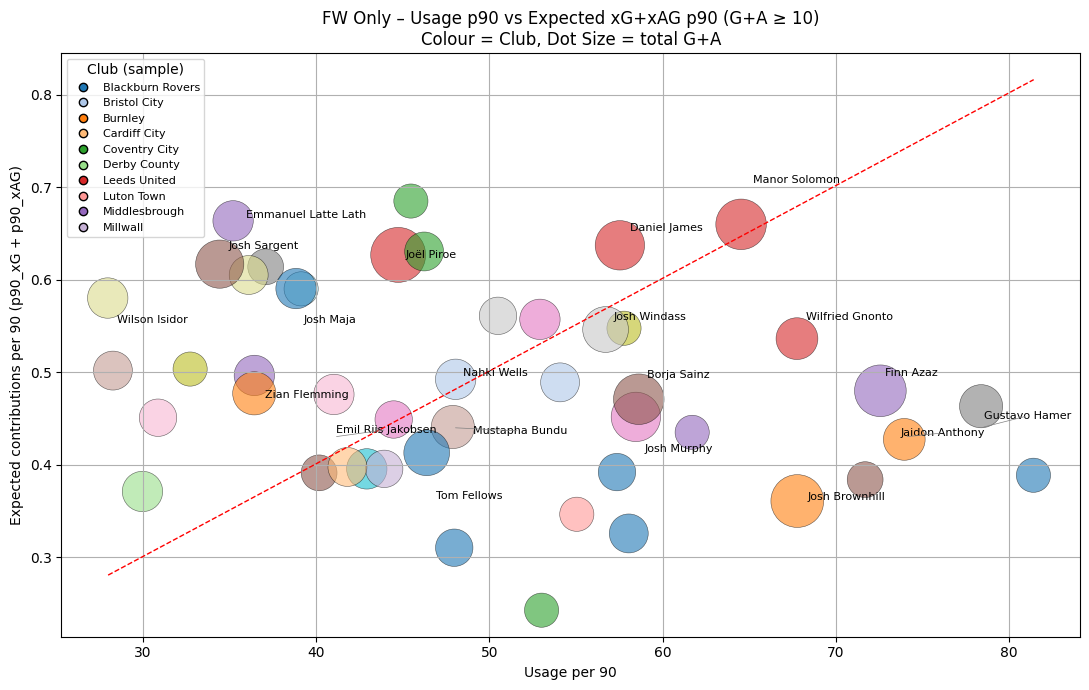

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

df_plot = df_fw.copy()

# Ensure expected column exists
if "p90_xg+xag" in df_plot.columns:
    df_plot["p90_xg_xag"] = df_plot["p90_xg+xag"]
else:
    df_plot["p90_xg_xag"] = df_plot["p90_xg"] + df_plot["p90_xag"]

required_plot = ["usage_p90", "p90_xg_xag", "g+a", "club", "player_name"]
missing_plot = [c for c in required_plot if c not in df_plot.columns]
if missing_plot:
    raise ValueError(f"Missing columns for plotting: {missing_plot}")

plt.figure(figsize=(11, 7))

size_factor = 60
sizes = (df_plot["g+a"].fillna(0) + 0.1) * size_factor

colors = df_plot["club"].map(club_to_color)

# ---------- JITTER ----------
jitter_x = 0.02
jitter_y = 0.02

x = df_plot["usage_p90"] + np.random.normal(0, jitter_x, len(df_plot))
y = df_plot["p90_xg_xag"] + np.random.normal(0, jitter_y, len(df_plot))

plt.scatter(
    x,
    y,
    s=sizes,
    c=colors,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.4,
)

plt.xlabel("Usage per 90")
plt.ylabel("Expected contributions per 90 (p90_xG + p90_xAG)")
plt.title(
    "FW Only – Usage p90 vs Expected xG+xAG p90 (G+A ≥ 10)\n"
    "Colour = Club, Dot Size = total G+A"
)
plt.grid(True)

# ---------- Reference line ----------
median_usage = df_plot["usage_p90"].median()
median_expected = df_plot["p90_xg_xag"].median()
scale = median_expected / median_usage

x_vals = np.linspace(df_plot["usage_p90"].min(),
                     df_plot["usage_p90"].max(), 200)
y_vals = x_vals * scale

plt.plot(x_vals, y_vals, linestyle="--", color="red", linewidth=1)

# ---------- NON-OVERLAPPING LABELS ----------
top = df_plot.sort_values("g+a", ascending=False).head(20)

texts = []
for _, row in top.iterrows():
    texts.append(
        plt.text(
            row["usage_p90"],
            row["p90_xg_xag"],
            row["player_name"],
            fontsize=8,
            weight="medium",
        )
    )

adjust_text(texts,
            expand_points=(1.2, 1.4),
            expand_text=(1.1, 1.2),
            arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5))

# Legend
handles = []
for club in clubs_sorted[:10]:
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markerfacecolor=club_to_color[club],
            markeredgecolor="k",
            markersize=6,
        )
    )

plt.legend(handles, clubs_sorted[:10], title="Club (sample)", loc="best", fontsize=8)

plt.tight_layout()
plt.show()


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


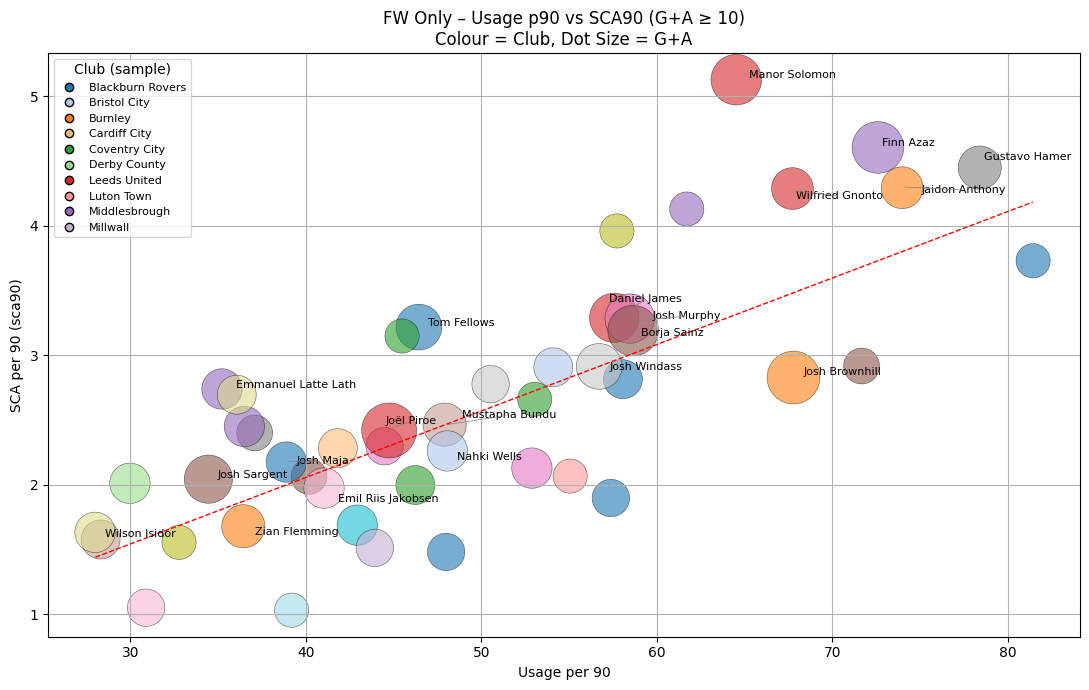

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

df_plot = df_fw.copy()

required_plot = ["usage_p90", "sca90", "g+a", "club", "player_name"]
missing_plot = [c for c in required_plot if c not in df_plot.columns]
if missing_plot:
    raise ValueError(f"Missing columns for plotting: {missing_plot}")

plt.figure(figsize=(11, 7))

size_factor = 60
sizes = (df_plot["g+a"].fillna(0) + 0.1) * size_factor

colors = df_plot["club"].map(club_to_color)

# ---------- JITTER ----------
jitter_x = 0.02
jitter_y = 0.02

x = df_plot["usage_p90"] + np.random.normal(0, jitter_x, len(df_plot))
y = df_plot["sca90"] + np.random.normal(0, jitter_y, len(df_plot))

plt.scatter(
    x,
    y,
    s=sizes,
    c=colors,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.4,
)

plt.xlabel("Usage per 90")
plt.ylabel("SCA per 90 (sca90)")
plt.title(
    "FW Only – Usage p90 vs SCA90 (G+A ≥ 10)\n"
    "Colour = Club, Dot Size = G+A"
)
plt.grid(True)

# ---------- Reference line ----------
median_usage = df_plot["usage_p90"].median()
median_sca = df_plot["sca90"].median()
scale = median_sca / median_usage

x_vals = np.linspace(df_plot["usage_p90"].min(),
                     df_plot["usage_p90"].max(), 200)
y_vals = x_vals * scale

plt.plot(x_vals, y_vals, linestyle="--", color="red", linewidth=1)

# ---------- NON-OVERLAPPING LABELS ----------
top = df_plot.sort_values("g+a", ascending=False).head(20)

texts = []
for _, row in top.iterrows():
    texts.append(
        plt.text(
            row["usage_p90"],
            row["sca90"],
            row["player_name"],
            fontsize=8,
            weight="medium",
        )
    )

adjust_text(texts,
            expand_points=(1.2, 1.4),
            expand_text=(1.1, 1.2),
            arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5))

# Legend
handles = []
for club in clubs_sorted[:10]:
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markerfacecolor=club_to_color[club],
            markeredgecolor="k",
            markersize=6,
        )
    )

plt.legend(handles, clubs_sorted[:10], title="Club (sample)", loc="best", fontsize=8)

plt.tight_layout()
plt.show()
